In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


# Data Creation and model prediction

In [10]:
def generate_synthetic_fico_data(n=10000):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 100, n) - np.random.choice([0, 20, 50, 100], n, p=[0.7, 0.15, 0.1, 0.05])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 850 - np.random.gamma(2, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data)/10 # Divide by 10 to scale down the values
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.45, 'Amounts Owed': 0.20, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)*10
    
    return df

def w(beta, gamma):
    """
    Applies the transformation to beta.
    
    Args:
    beta (float): The input weight.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    float: The transformed weight.
    """
    return np.exp(-(-np.log(beta))**gamma)


def behavioral(weights, gamma):
    """
    Modifies the weights according to the specified formula.
    
    Args:
    weights (np.array): Original model weights.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    np.array: Modified weights reflecting behavioral adjustments.
    """
    sorted_indices = np.argsort(weights)  # Sort indices of weights
    sorted_weights = weights[sorted_indices]  # Sort weights
    transformed_weights = [w(beta, gamma) for beta in sorted_weights]
    
    perceived_weights = np.zeros_like(weights)
    for i in range(len(weights)):
        sum_current = sum(transformed_weights[i:])
        sum_next = sum(transformed_weights[i+1:]) if i+1 < len(weights) else 0
        perceived_weights[sorted_indices[i]] = sum_current - sum_next

    return perceived_weights

# Generate the dataset
df = generate_synthetic_fico_data()
fico_df = df.copy()

In [11]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] > np.random.rand(fico_df.shape[0])).astype(int)

In [12]:
fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,74.967142,70.628527,69.0,67.0,74.109675,723.218866,0.999340,1
1,68.617357,56.853743,62.4,68.5,71.943185,656.528778,0.657659,1
2,76.476885,78.282140,55.9,60.9,53.547595,699.007859,0.992614,1
3,85.230299,77.983842,50.0,60.9,77.494880,752.898908,0.999966,1
4,67.658466,80.269939,84.8,63.8,78.152849,734.155825,0.999779,1
5,67.658630,70.390724,41.7,66.4,77.651800,651.847084,0.546046,0
6,85.792128,65.263829,81.3,71.2,75.069204,784.811438,0.999999,1
7,75.674347,79.464831,53.0,65.7,25.607051,670.271276,0.883616,1
8,65.305256,73.287671,31.6,84.3,74.226931,646.375927,0.410377,1
9,73.425600,74.443342,79.5,63.6,51.463939,713.615825,0.998276,1


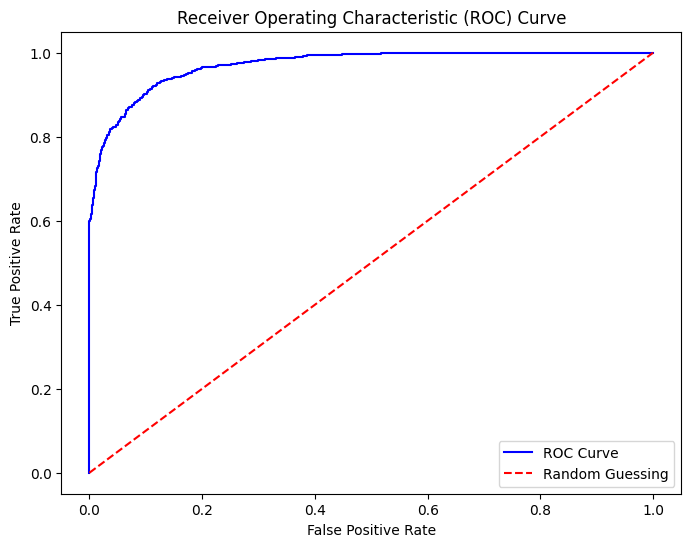

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import numpy as np

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df['True Label']  # the target variable

# Splitting the dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)


# Get the predicted probabilities for the test set
y_scores = model.predict_proba(X_test)[:, 1]

# Calculate the FPR and TPR at different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()


In [14]:
# Fit the model with all features
model_full = LogisticRegression()
model_full.fit(X_train, y_train)

# Get the feature names and their corresponding coefficients from the model
feature_names = X.columns
coefficients = model_full.coef_[0]

# Printing feature weights
print("Feature weights:")
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")

Feature weights:
Payment History: 0.4520
Amounts Owed: 0.1951
Length of Credit History: 0.1506
Credit Mix: 0.0889
New Credit: 0.1055


In [15]:
# print perceived weights
perceived_weights = behavioral(coefficients, gamma=0.5)
print("\nPerceived Feature weights:")
for feature, coef in zip(feature_names, perceived_weights):
    print(f"{feature}: {coef:.4f}")


Perceived Feature weights:
Payment History: 0.4102
Amounts Owed: 0.2785
Length of Credit History: 0.2526
Credit Mix: 0.2110
New Credit: 0.2232


# Better optimization (more realistic)

Initial Firm Payoff: 1833.4
Success rate of gaming the system (Non-behavioral): 7.75%
Success rate of gaming the system (Behavioral): 7.18%
Change in firm's payoff after manipulation (non-behavioral case): -13.600000000000001
Change in firm's payoff after manipulation (behavioral case): -12.600000000000001


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


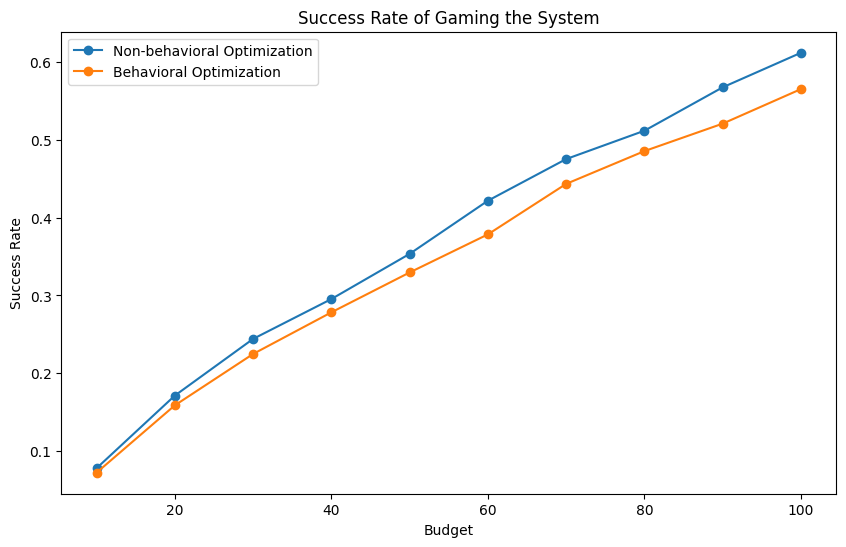

In [18]:
import cvxpy as cp
import numpy as np
import pandas as pd
# import seaborn as sns

# Optimization function to maximize score given the budget
def optimize_features_log(current_features, budget, weights, threshold):
    # Number of features
    n_features = len(current_features)
    
    # Define the optimization variables (amount to increase each feature)
    x = cp.Variable(n_features, nonneg=True)
    
    # Objective function: maximize the weighted sum of features (proxy for FICO score)
    objective = cp.Maximize(cp.sum(cp.multiply(weights, cp.log1p( x / (1 + current_features) ))))
    
    # Constraints
    constraints = [
        cp.sum(x) <= budget,          # Total budget constraint
        # cp.sum(cp.multiply(weights, cp.log1p(x) + current_features)) == threshold  # Total score threshold constraint
    ]
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Return the new feature values if the problem is feasible, new feature values = current feature values + ln(1 + x/(1 + current feature values))
    if problem.status == cp.OPTIMAL:
        return current_features + 10*np.log1p(x.value / (1 + current_features))
    else:
        return current_features

# Predict initial labels
initial_predictions = model.predict(X_test)

# Print firm payoff for the initial model: (number of true positives) - (0.2 * number of false positives)
initial_firm_payoff = np.sum((y_test == 1) & (initial_predictions == 1)) - 0.2*np.sum((y_test == 0) & (initial_predictions == 1))
print(f"Initial Firm Payoff: {initial_firm_payoff}")

# Find users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask]
y_to_optimize = y_test[mask]

gamma = 0.5  # Example gamma value
budget = 10  # Define some budget
threshold = 680  # Define some threshold
model_weights = model.coef_[0]  # Actual model weights
perceived_weights = behavioral(model_weights, gamma)

# Predict initial labels
initial_predictions = model.predict(X_test)

# Select users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask].copy()

# Optimization using original weights
optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=model_weights, threshold=threshold)

# Optimization using perceived weights
optimized_features_perceived = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=perceived_weights, threshold=threshold)

# Predict with the optimized features
optimized_predictions_original = model.predict(optimized_features_original)
optimized_predictions_perceived = model.predict(optimized_features_perceived)

# Calculate success rate
success_rate_original = np.mean(optimized_predictions_original == 1)
print(f"Success rate of gaming the system (Non-behavioral): {success_rate_original:.2%}")

success_rate_perceived = np.mean(optimized_predictions_perceived == 1)
print(f"Success rate of gaming the system (Behavioral): {success_rate_perceived:.2%}")

# Firm payoff for the optimized model
optimized_firm_payoff = np.sum((y_to_optimize == 1) & (optimized_predictions_original == 1)) - 0.2*np.sum((y_to_optimize == 0) & (optimized_predictions_original == 1))
print(f"Change in firm's payoff after manipulation (non-behavioral case): {optimized_firm_payoff}")

optimized_firm_payoff = np.sum((y_to_optimize == 1) & (optimized_predictions_perceived == 1)) - 0.2*np.sum((y_to_optimize == 0) & (optimized_predictions_perceived == 1))
print(f"Change in firm's payoff after manipulation (behavioral case): {optimized_firm_payoff}")


# do the same for multiple budgets
budgets = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
success_rates_original = []
success_rates_perceived = []

for budget in budgets:
    # Optimization using original weights
    optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=model_weights, threshold=threshold)

    # Optimization using perceived weights
    optimized_features_perceived = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=perceived_weights, threshold=threshold)

    # Predict with the optimized features
    optimized_predictions_original = model.predict(optimized_features_original)
    optimized_predictions_perceived = model.predict(optimized_features_perceived)

    # Calculate success rate
    success_rate_original = np.mean(optimized_predictions_original == 1)
    success_rates_original.append(success_rate_original)

    success_rate_perceived = np.mean(optimized_predictions_perceived == 1)
    success_rates_perceived.append(success_rate_perceived)

# Plotting the success rates
plt.figure(figsize=(10, 6))
plt.plot(budgets, success_rates_original, marker='o', label='Non-behavioral Optimization')
plt.plot(budgets, success_rates_perceived, marker='o', label='Behavioral Optimization')
plt.xlabel('Budget')
plt.ylabel('Success Rate')
plt.title('Success Rate of Gaming the System')
plt.legend()
plt.show()

In [19]:
# plot success rate for different gamma values
budget = 60
gammas = np.linspace(0, 1, 10)
success_rates_p = []
success_rates_o = []
firm_payoffs_p = []
firm_payoffs_o = []
iterations = 1

# Optimization using original weights
optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=model_weights, threshold=threshold)

# Predict with the optimized features (original weights)
optimized_predictions_original = model.predict(optimized_features_original)

# Calculate success rate (original weights)
success_rate_o = np.mean(optimized_predictions_original == 1)

# Calculate firm payoff (original weights)
firm_payoff_o = np.sum((y_to_optimize == 1) & (optimized_predictions_original == 1)) - 0.2*np.sum((y_to_optimize == 0) & (optimized_predictions_original == 1))

for gamma in gammas:
    success_rate_p = 0
    firm_payoff_p = 0
    
    # Select users who are true negatives and predicted negatives
    mask = (y_test == 0) & (initial_predictions == 0)
    X_to_optimize = X_test[mask].copy()

    # Optimization using perceived weights
    optimized_features_perceived = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=behavioral(model_weights, gamma), threshold=threshold)
    
    # Predict with the optimized features (perceived weights)
    optimized_predictions_perceived = model.predict(optimized_features_perceived)

    # Calculate success rate (perceived weights)
    success_rate_p += np.mean(optimized_predictions_perceived == 1)

    # Calculate firm payoff (perceived weights)
    firm_payoff_p = np.sum((y_to_optimize == 1) & (optimized_predictions_perceived == 1)) - 0.2*np.sum((y_to_optimize == 0) & (optimized_predictions_perceived == 1))
    firm_payoffs_p.append(firm_payoff_p)

    success_rates_p.append(success_rate_p / iterations)

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


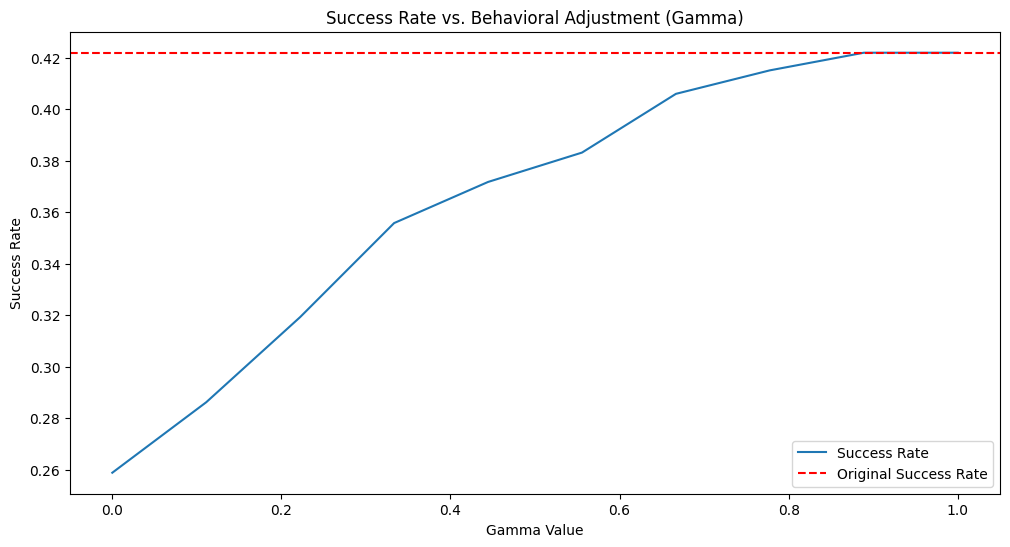

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(gammas, success_rates_p, label='Success Rate')
# plot original success rate
plt.axhline(y=success_rate_o, color='r', linestyle='--', label='Original Success Rate')
plt.xlabel('Gamma Value')
plt.ylabel('Success Rate')
plt.title('Success Rate vs. Behavioral Adjustment (Gamma)')
plt.legend()
plt.show()

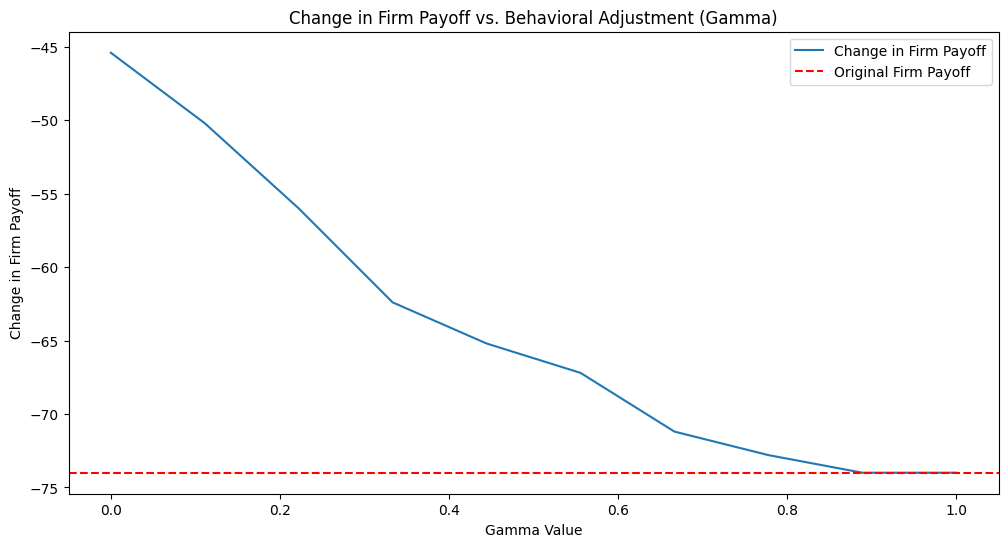

In [21]:
# Plot the firm payoff for different gamma values
plt.figure(figsize=(12, 6))
plt.plot(gammas, firm_payoffs_p, label='Change in Firm Payoff')
# plot original firm payoff
plt.axhline(y=firm_payoff_o, color='r', linestyle='--', label='Original Firm Payoff')
plt.xlabel('Gamma Value')
plt.ylabel('Change in Firm Payoff')
plt.title('Change in Firm Payoff vs. Behavioral Adjustment (Gamma)')
plt.legend()

In [25]:
# budget = 60  # Define a budget
# gamma = 0.5  # Example gamma value

# # Select a subset for demonstration (one row for simplicity)
# current_features = X_test.iloc[90].values

# # Optimize features
# optimized_features = optimize_features_log(current_features, budget, model_weights, threshold=threshold)
# # For behavioral optimization
# optimized_features_perceived = optimize_features_log(current_features, budget, weights=behavioral(model_weights, gamma), threshold=threshold)

# # Calculate the changes made to each feature
# changes_made = optimized_features - current_features
# changes_made_perceived = optimized_features_perceived - current_features

# # Display the changes for each feature
# print("Changes made to each feature:")
# print(changes_made)
# print("\nChanges made to each feature (perceived weights):")
# print(changes_made_perceived)

Changes made to each feature:
[7.79173340e+00 5.34711262e-08 2.31587762e-08 1.08091172e-08
 1.50089789e-08]

Changes made to each feature (perceived weights):
[7.14549062e+00 1.03512178e+00 1.09054270e-07 2.98826137e-08
 5.93458083e-08]


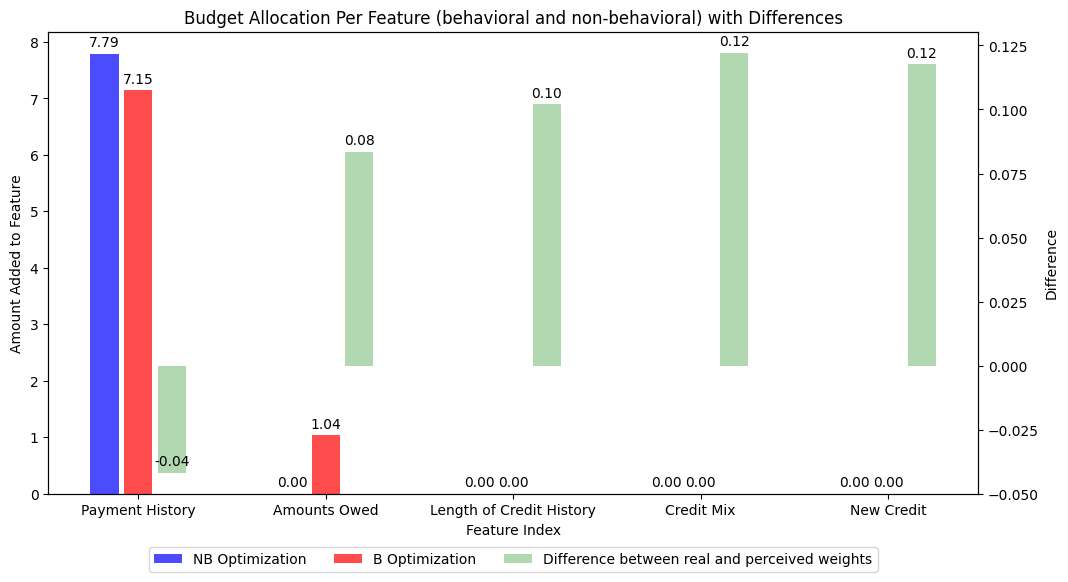

In [26]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming changes_made, changes_made_perceived, model_weights, and perceived_weights are defined
# differences = perceived_weights - model_weights
# df = pd.DataFrame({
#     'Feature Index': list(range(len(changes_made))) * 3,  # Repeating for each type of data
#     'Changes Made': list(changes_made) + list(changes_made_perceived) + list(differences),
#     'Type': ['Real Weights']*len(changes_made) + ['Perceived Weights']*len(changes_made_perceived) + ['Difference']*len(differences),
#     'Weight Labels': ['NB: {:.1f}'.format(w) for w in model_weights] + ['B: {:.1f}'.format(w) for w in perceived_weights] + ['Diff: {:.1f}'.format(d) for d in differences]
# })


# # Set up the plot
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Locations of the groups
# ind = np.arange(len(changes_made))  # the x locations for the groups
# width = 0.15  # the width of the bars

# # Plot bars for real and perceived weights on primary y-axis
# rects1 = ax1.bar(ind - 1.2*width, changes_made, width, label='NB Optimization', color='blue', alpha=0.7)
# rects2 = ax1.bar(ind, changes_made_perceived, width, label='B Optimization', color='red', alpha=0.7)

# # Create secondary y-axis
# ax2 = ax1.twinx()
# # Plot bars for differences on secondary y-axis
# rects3 = ax2.bar(ind + 1.2*width, differences, width, label='Difference between real and perceived weights', color='green', alpha=0.3)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax1.set_xlabel('Feature Index')
# ax1.set_ylabel('Amount Added to Feature')
# ax2.set_ylabel('Difference')
# ax1.set_title('Budget Allocation Per Feature (behavioral and non-behavioral) with Differences')
# ax1.set_xticks(ind)
# # feature names as x-axis labels
# ax1.set_xticklabels(['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit'])

# # Combine legends from both axes
# handles1, labels1 = ax1.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

# # Attach a text label above each bar in rects1 and rects2, displaying height.
# def autolabel(rects, axis):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         axis.annotate('{:.2f}'.format(height),
#                       xy=(rect.get_x() + rect.get_width() / 2, height),
#                       xytext=(0, 3),  # 3 points vertical offset
#                       textcoords="offset points",
#                       ha='center', va='bottom')

# autolabel(rects1, ax1)
# autolabel(rects2, ax1)
# autolabel(rects3, ax2)

# plt.show()


Case 0:
Current Features: [96.37881752 68.40021812 42.6        64.2        61.89291704]


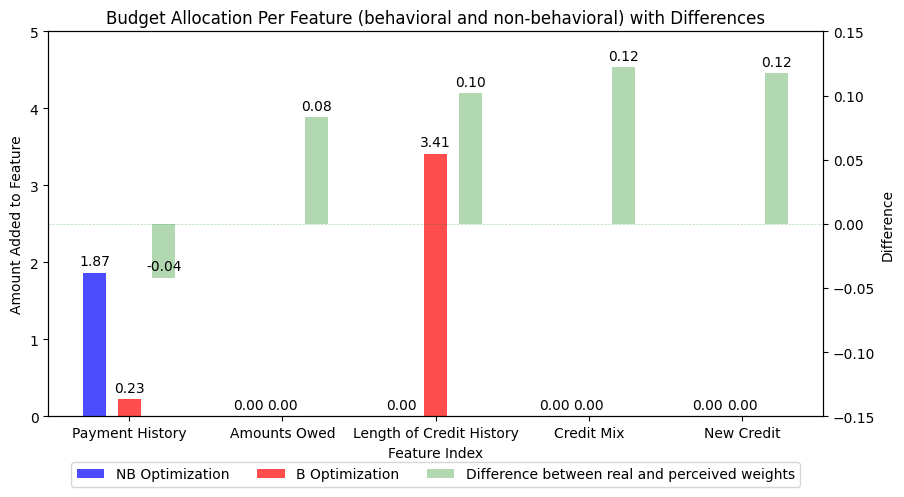

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 10:
Current Features: [87.55475698 80.5534388  75.7        70.6        49.56321858]


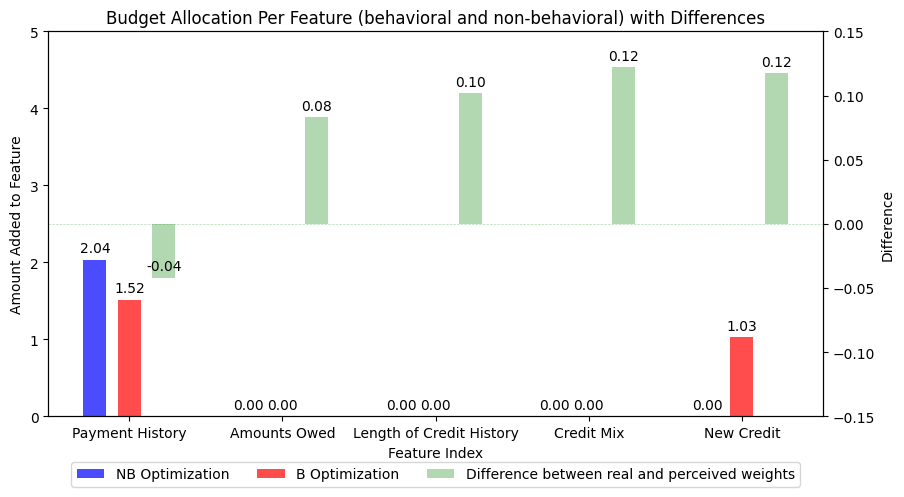

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 20:
Current Features: [65.56570582 66.47478254 79.         80.3        61.26013099]


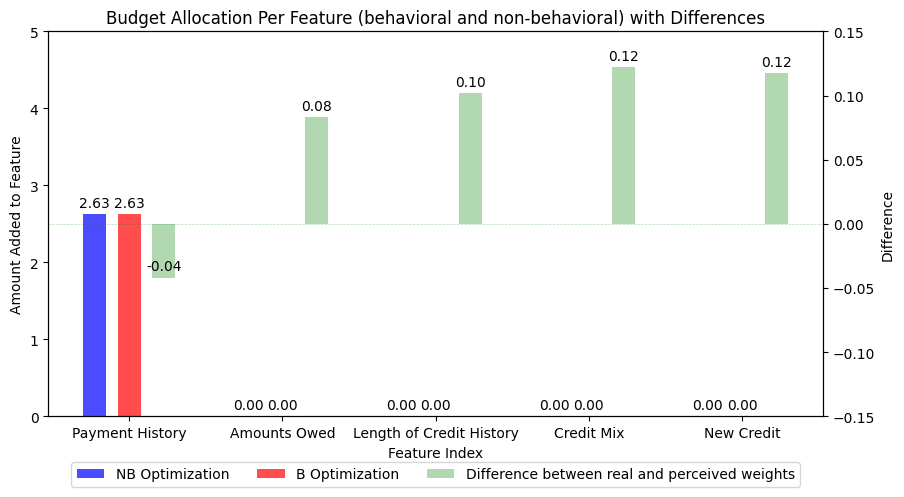

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 30:
Current Features: [75.95157025 79.64468503 48.1        83.3        41.64318347]


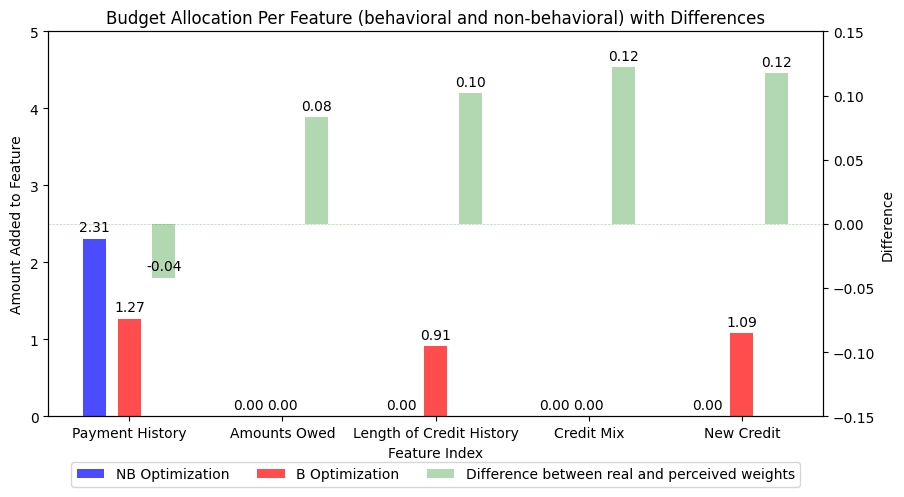

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 40:
Current Features: [74.68978078 57.21833377 49.6        78.         71.52280384]


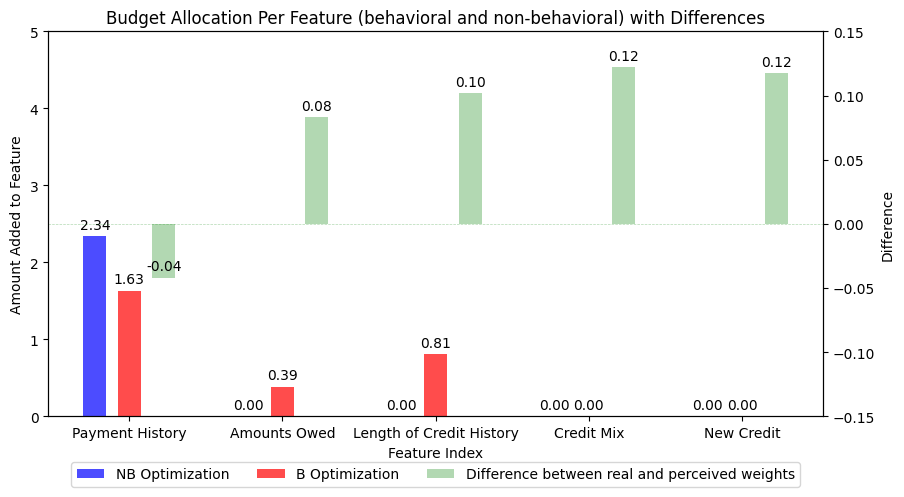

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 50:
Current Features: [52.13624535 73.95888108 61.         73.2        53.48963816]


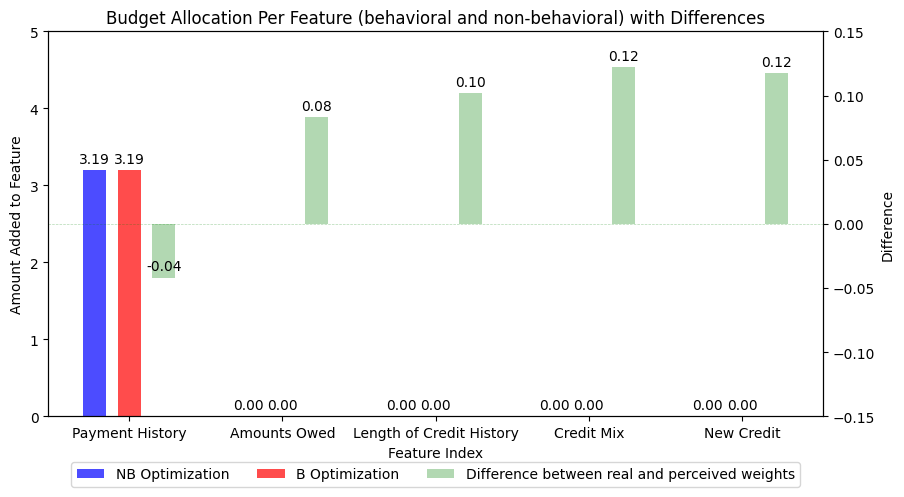

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 60:
Current Features: [75.50052099 83.57183643 43.7        63.7        77.9466601 ]


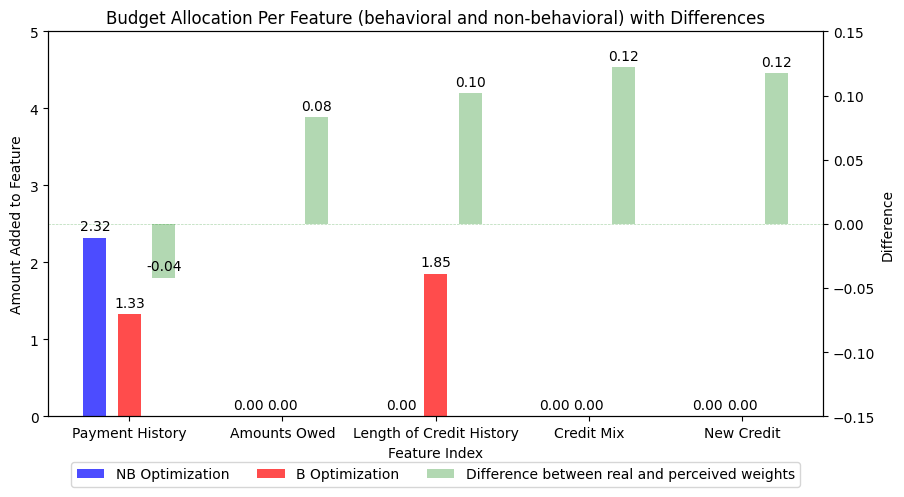

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 70:
Current Features: [67.1030304  71.25710165 68.1        73.2        65.05292185]


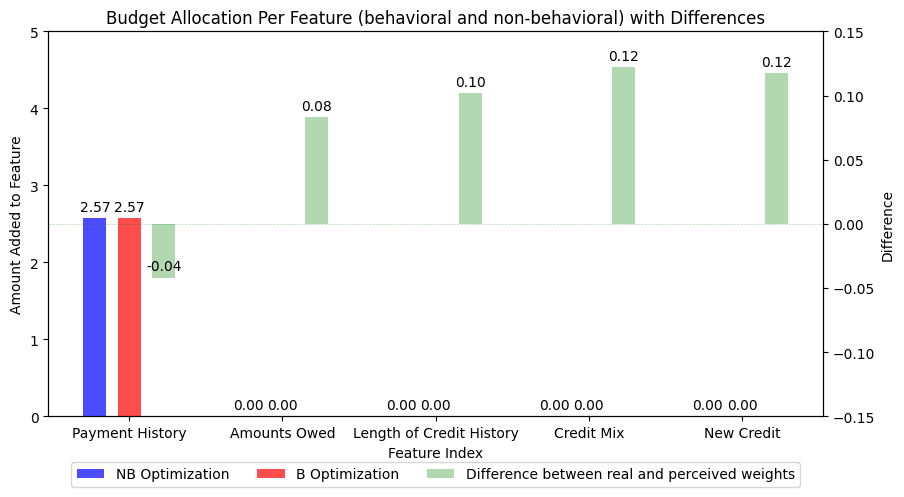

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 80:
Current Features: [52.55467111 78.93723761 78.3        72.2        51.57940246]


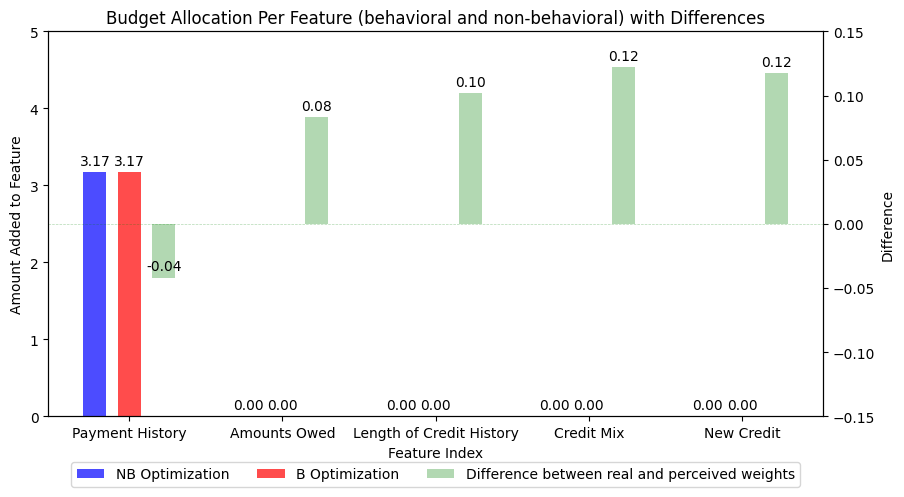

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 90:
Current Features: [49.86169499 62.61463696 68.         84.8        71.98550422]


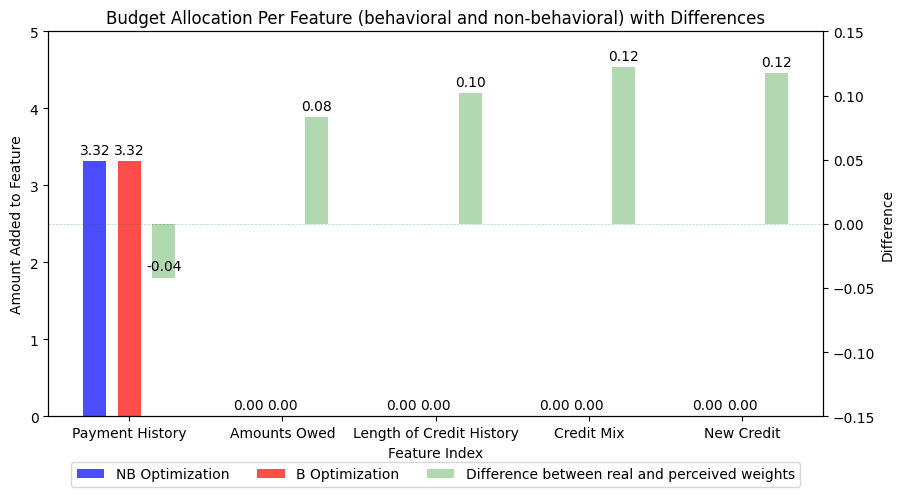

------------------------------------------------------------------------------------------------------------------------------------------------------


Case 100:
Current Features: [81.49273326 49.98442669 33.4        82.6        45.17049377]


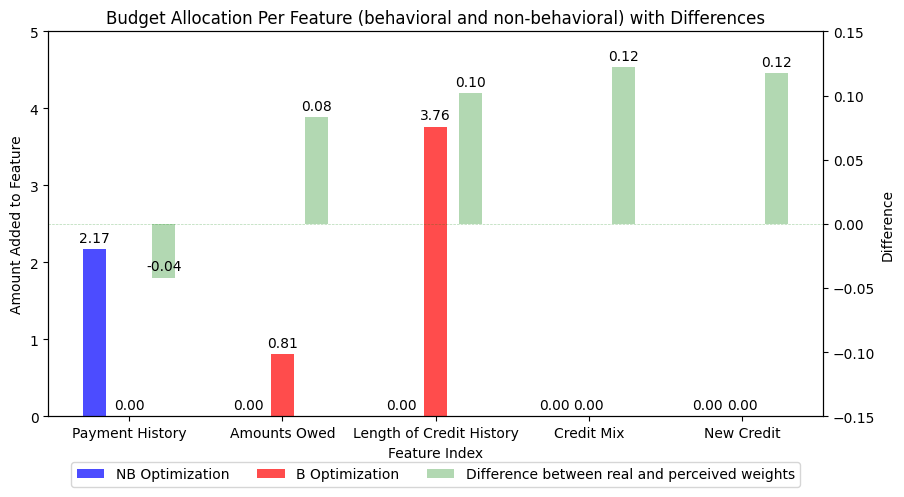

------------------------------------------------------------------------------------------------------------------------------------------------------




In [29]:
# plot the same for multiple cases
budget = 20  # Define a budget
gamma = 0.5  # Example gamma value
threshold = 680  # Define a threshold
cases = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for case in cases:
    # Select a subset for demonstration (one row for simplicity)
    current_features = X_test.iloc[case].values
    print(f"Case {case}:")
    print(f"Current Features: {current_features}")

    # Optimize features
    optimized_features = optimize_features_log(current_features, budget, model_weights, threshold=threshold)
    # For behavioral optimization
    optimized_features_perceived = optimize_features_log(current_features, budget, weights=behavioral(model_weights, gamma), threshold=threshold)

    # Calculate the changes made to each feature
    changes_made = optimized_features - current_features
    changes_made_perceived = optimized_features_perceived - current_features

    # # Display the changes for each feature
    # print("Changes made to each feature:")
    # print(changes_made)
    # print("\nChanges made to each feature (perceived weights):")
    # print(changes_made_perceived)

    import pandas as pd

    # Assuming changes_made, changes_made_perceived, model_weights, and perceived_weights are defined
    differences = perceived_weights - model_weights
    df = pd.DataFrame({
        'Feature Index': list(range(len(changes_made))) * 3,  # Repeating for each type of data
        'Changes Made': list(changes_made) + list(changes_made_perceived) + list(differences),
        'Type': ['Real Weights']*len(changes_made) + ['Perceived Weights']*len(changes_made_perceived) + ['Difference']*len(differences),
        'Weight Labels': ['NB: {:.1f}'.format(w) for w in model_weights] + ['B: {:.1f}'.format(w) for w in perceived_weights] + ['Diff: {:.1f}'.format(d) for d in differences]
    })

    import matplotlib.pyplot as plt
    import numpy as np

    # Set up the plot
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Locations of the groups
    ind = np.arange(len(changes_made))  # the x locations for the groups
    width = 0.15  # the width of the bars

    # Plot bars for real and perceived weights on primary y-axis
    rects1 = ax1.bar(ind - 1.5*width, changes_made, width, label='NB Optimization', color='blue', alpha=0.7)
    rects2 = ax1.bar(ind, changes_made_perceived, width, label='B Optimization', color='red', alpha=0.7)

    # Create secondary y-axis
    ax2 = ax1.twinx()
    # Plot bars for differences on secondary y-axis
    rects3 = ax2.bar(ind + 1.5*width, differences, width, label='Difference between real and perceived weights', color='green', alpha=0.3)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_xlabel('Feature Index')
    ax1.set_ylabel('Amount Added to Feature')
    ax2.set_ylabel('Difference')
    ax1.set_title('Budget Allocation Per Feature (behavioral and non-behavioral) with Differences')
    ax1.set_xticks(ind)
    # feature names as x-axis labels
    ax1.set_xticklabels(['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit'])

    # set the y-axis limits
    ax1.set_ylim(0, 5)
    ax2.set_ylim(-0.15, 0.15)
    # horizontal line for 0 difference
    ax2.axhline(0, color='green', linewidth=0.5, linestyle='--', alpha=0.3)

    # Combine legends from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    # Attach a text label above each bar in rects1 and rects2, displaying height.
    def autolabel(rects, axis):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axis.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1, ax1)
    autolabel(rects2, ax1)
    autolabel(rects3, ax2)

    plt.show()

    print('-'*150)
    print('\n')


# Closing the loop --> The firm chooses optimal weights

In [30]:
import numpy as np

# Generate the dataset (original)
df_2 = generate_synthetic_fico_data()
fico_df_2 = df_2.copy()

# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df_2['Approval Probability'] = sigmoid(fico_df_2['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df_2['True Label'] = (fico_df_2['Approval Probability'] > np.random.rand(fico_df_2.shape[0])).astype(int)

# Drop the FICO Score and Approval Probability columns
fico_df_2.drop(['FICO Score', 'Approval Probability'], axis=1, inplace=True)

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df_2[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df_2['True Label']  # the target variable

In [33]:
import numpy as np
import cvxpy as cp
from alive_progress import alive_bar
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def optimize_features_log(current_features, budget, weights):
    n_features = len(current_features)
    x = cp.Variable(n_features, nonneg=True)
    objective = cp.Maximize(cp.sum(cp.multiply(weights, cp.log1p(x / (1 + current_features)))))
    constraints = [cp.sum(x) <= budget]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    if problem.status == cp.OPTIMAL:
        return x.value + current_features
    else:
        return current_features

def simulate_feature_manipulation(X, budget, weights):
    return X.apply(optimize_features_log, axis=1, budget=budget, weights=weights)

def evaluate_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Splitting the dataset
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train_0, y_train_0)


# Initialize weights
weights = model_full.coef_[0]

# Define optimization parameters
max_iterations = 100
tolerance = 1e-5
budget = 20

new_weights = weights

with alive_bar(max_iterations, title="Optimization Progress") as bar:
    for _ in range(max_iterations):
        X_train, X_test, y_train, y_test = X_train_0, X_test_0, y_train_0, y_test_0

        # Simulate feature manipulation
        X_train_optimized = simulate_feature_manipulation(X_train, budget, new_weights)

        # Fit the model with the optimized features
        model_optimized = LogisticRegression()
        model_optimized.fit(X_train_optimized, y_train)
        new_weights = model_optimized.coef_[0]

        print(f"New Weights for iteration {_ + 1}: {new_weights}")

        # Check for convergence
        if np.linalg.norm(new_weights - weights) < tolerance:
            # Final weights to announce
            announced_weights = new_weights
            break

        # Update the progress bar
        bar()

# announced weights and the original weights
print("Original Weights:")
for feature, coef in zip(feature_names, weights):
    print(f"{feature}: {coef:.4f}")

print("\nAnnounced Weights:")
for feature, coef in zip(feature_names, announced_weights):
    print(f"{feature}: {coef:.4f}")


# Select users who are true negatives and predicted negatives
mask = (y_test == 0) & (initial_predictions == 0)
X_to_optimize = X_test[mask].copy()

# Optimization using original weights
optimized_features_original = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=weights, threshold=threshold)

# Optimization using announced weights
optimized_features_announced = X_to_optimize.apply(optimize_features_log, axis=1, budget=budget, weights=announced_weights, threshold=threshold)

# Predict with the optimized features
optimized_predictions_original = model.predict(optimized_features_original)
optimized_predictions_announced = model.predict(optimized_features_announced)

# Calculate success rate
success_rate_original = np.mean(optimized_predictions_original == 1)
print(f"Success rate of gaming the system with original weights: {success_rate_original:.2%}")

success_rate_announced = np.mean(optimized_predictions_announced == 1)
print(f"Success rate of gaming the system with optimal weights: {success_rate_announced:.2%}")


on 0: New Weights for iteration 1: [0.44288388 0.19163498 0.14790424 0.08723732 0.09876851]


on 0: /Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
        warnings.warn(


on 1: New Weights for iteration 2: [0.4441397  0.19213474 0.14819392 0.08748028 0.09940811]
on 2: New Weights for iteration 3: [0.44404739 0.19211276 0.14817917 0.08747126 0.09936031]
on 3: New Weights for iteration 4: [0.44319916 0.19202789 0.14798311 0.08756331 0.09882393]


on 3: /Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
        warnings.warn(


on 4: New Weights for iteration 5: [0.4441398  0.19213514 0.14819533 0.08748139 0.09940995]
on 5: New Weights for iteration 6: [0.44404307 0.19210787 0.14817879 0.08746792 0.0993609 ]
on 6: New Weights for iteration 7: [0.44404696 0.19210311 0.1481783  0.08746516 0.09936092]
on 7: New Weights for iteration 8: [0.4440392  0.19209876 0.14817622 0.08746118 0.09936103]
on 8: New Weights for iteration 9: [0.44406489 0.19212124 0.14818314 0.08746077 0.09936382]
on 9: New Weights for iteration 10: [0.44404003 0.19209923 0.14817676 0.08746141 0.09936133]
on 10: New Weights for iteration 11: [0.44403758 0.19209831 0.14817569 0.08746104 0.09936041]
Optimization Progress |████▍⚠︎                                  | (!) 11/100 [11%] in 4:44.0 (0.04/s) 


KeyboardInterrupt: 